# DCGAN on Cartoon Set 10k by Google https://google.github.io/cartoonset/

### This notebook is based on Tensorflow tutorial on DCGAN

## Import Libraries and define directories

In [1]:
import tensorflow as tf
from keras.preprocessing import image

C:\Users\utkar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\utkar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\utkar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\utkar\AppData\Roaming\

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tqdm

from IPython import display

In [3]:
curr_path = os.getcwd()

In [4]:
data_dir = curr_path + '/data/'
checkpoint_dir = curr_path + '/training_checkpoints/'
output_dir = curr_path + '/output/'

In [5]:
print("Current working directory : ", curr_path)
print("Data directory : ", data_dir)

Current working directory :  C:\Users\utkar\Documents\Deep Learning Practice\cartoon-set-dcgan
Data directory :  C:\Users\utkar\Documents\Deep Learning Practice\cartoon-set-dcgan/data/


In [6]:
train_images_list = os.listdir(data_dir)

## Load images in Numpy array

In [29]:
# Function to load images from image path
def load_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img = image.img_to_array(img)
    return img

In [30]:
# Try loading a sample image

img = load_image(data_dir + train_images_list[100])
print(img.shape)

(64, 64, 3)


In [31]:
# Load all images in array train_images
def load_images(data_dir):
    
    train_images = []

    for img in tqdm.tqdm(train_images_list):

        img = load_image(data_dir + img)
        train_images.append(np.clip(img/255, 0, 1))

    train_images = np.array(train_images)
    train_images = (train_images - 0.5)*2
    train_images = np.clip(train_images, -1, 1)
    print("Shape of training images : ", train_images.shape)
    
    return train_images

In [32]:
# Load images 
train_images = load_images(data_dir)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 181.64it/s]


Shape of training images :  (10000, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

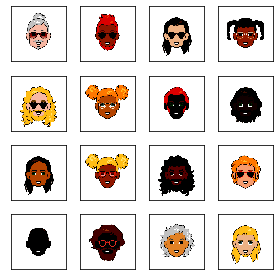

In [33]:
# Function to plot images
def plot(arr):

    fig = plt.figure(figsize=(4,4))
    for i in range(0, 16):
        plt.subplot(4, 4, 1 + i, xticks=[], yticks=[])
        plt.imshow(arr[i])

    plt.tight_layout()
    
    return plt
    
plt = plot(train_images)

In [34]:
# Define buffer and batch size

BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [36]:
# Generator based on Tensorflow's DCGAN generator with minor modifications

def generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

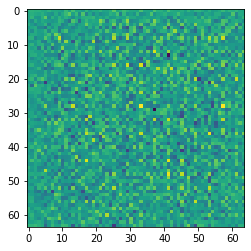

In [37]:
# Create generator model and test with a random sample noise 
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [38]:
generated_image.shape

TensorShape([1, 64, 64, 3])

## Discriminator

In [51]:
# Discriminator based on Tensorflow's DCGAN Discriminator with minor modifications

def discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [52]:
# Create discriminator model and test

discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040439]], shape=(1, 1), dtype=float32)


## Loss 

In [53]:
# Binary Crossentropy Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [54]:
def discriminator_loss(real_output, fake_output):
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [55]:
def generator_loss(fake_output):
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [56]:
# Optimizers 

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [57]:
# Keep checkpoints

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [58]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [59]:
# Train step function as defined in the tensorflow tutorial. 

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [60]:
# Define train functions as per Tensorflow tutorial 

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs,  seed)

In [61]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    plt = plot(predictions)

    plt.savefig(output_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

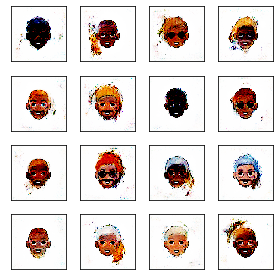

In [62]:
train(train_dataset, EPOCHS)